In [1]:
%matplotlib inline

In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as sp_rot

import torch

from aspire.abinitio import CLSyncVoting
from aspire.basis import FSPCABasis, FFBBasis2D, FFBBasis3D
from aspire.classification import BFSReddyChatterjiAverager2D, RIRClass2D
from aspire.denoising import DenoiserCov2D
from aspire.noise import AnisotropicNoiseEstimator, CustomNoiseAdder
from aspire.operators import FunctionFilter, RadialCTFFilter
from aspire.reconstruction import MeanEstimator
from aspire.source import Simulation
from aspire.utils.coor_trans import (
    get_aligned_rotations,
    get_rots_mse,
    register_rotations,
)
from aspire.volume import Volume

logger = logging.getLogger(__name__)

In [3]:
sim = "small"

if sim == "small":
    interactive = True  # Draw blocking interactive plots?
    do_cov2d = False  # Use CWF coefficients
    img_size = 32  # Downsample the volume to a desired resolution
    num_imgs = 10000  # How many images in our source.
    n_classes = 1000  # How many class averages to compute.
    n_nbor = 10  # How many neighbors to stack
    noise_variance = 5e-7  # Set a target noise variance

if sim == "medium":
    interactive = True  # Draw blocking interactive plots?
    do_cov2d = False  # Use CWF coefficients
    img_size = 64  # Downsample the volume to a desired resolution
    num_imgs = 20000  # How many images in our source.
    n_classes = 2000  # How many class averages to compute.
    n_nbor = 10  # How many neighbors to stack
    noise_variance = 5e-5  # Set a target noise variance

if sim == "large":
    interactive = True  # Draw blocking interactive plots?
    do_cov2d = False  # Use CWF coefficients
    img_size = 129  # Downsample the volume to a desired resolution
    num_imgs = 30000  # How many images in our source.
    n_classes = 2000  # How many class averages to compute.
    n_nbor = 20  # How many neighbors to stack
    noise_variance = 5e-7  # Set a target noise variance

## Simulation Data
Start with a fairly hi-res volume available from EMPIAR/EMDB.
https://www.ebi.ac.uk/emdb/EMD-2660
https://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-2660/map/emd_2660.map.gz



2023-03-06 17:43:01,864 INFO [aspire.volume.volume] map-data/emd_14930.map.gz with dtype float32 loaded as <class 'numpy.float64'>
2023-03-06 17:43:01,933 INFO [__main__] Original volume map data shape: (1, 280, 280, 280) dtype:float64
2023-03-06 17:43:01,934 INFO [__main__] Downsampling to (32, 32, 32)
2023-03-06 17:43:04,065 INFO [__main__] Initialize CTF filters.
2023-03-06 17:43:04,079 INFO [aspire.source.image] Creating Simulation with 10000 images.
2023-03-06 17:43:04,122 INFO [aspire.source.simulation] Appending CustomNoiseAdder to generation pipeline
2023-03-06 17:43:04,131 INFO [aspire.nufft] Trying NFFT backend cufinufft
2023-03-06 17:43:04,133 INFO [aspire.nufft] NFFT backend cufinufft not usable:
	No module named 'pycuda'
2023-03-06 17:43:04,135 INFO [aspire.nufft] Trying NFFT backend finufft
2023-03-06 17:43:04,146 INFO [aspire.nufft] NFFT backend finufft usable.
2023-03-06 17:43:04,148 INFO [aspire.nufft] Trying NFFT backend pynfft
2023-03-06 17:43:04,149 INFO [aspire.nuf

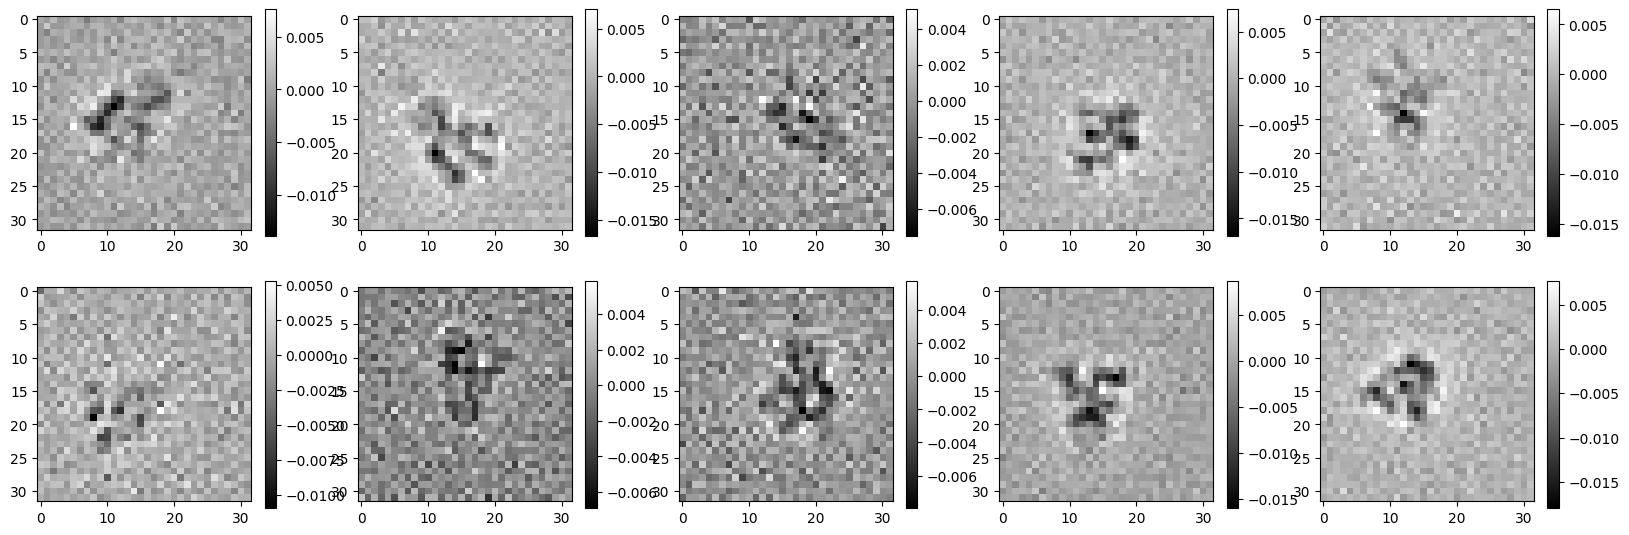

2023-03-06 17:43:06,386 INFO [__main__] Perform phase flip to input images.
2023-03-06 17:43:06,390 INFO [aspire.source.image] Perform phase flip on source object
2023-03-06 17:43:06,391 INFO [aspire.source.image] Adding Phase Flip Xform to end of generation pipeline


100%|██████████| 20/20 [00:16<00:00,  1.19it/s]

2023-03-06 17:43:23,262 INFO [aspire.source.image] Whitening source object
2023-03-06 17:43:23,264 INFO [aspire.source.image] Transforming all CTF Filters into Multiplicative Filters
2023-03-06 17:43:23,265 INFO [aspire.source.image] Adding Whitening Filter Xform to end of generation pipeline


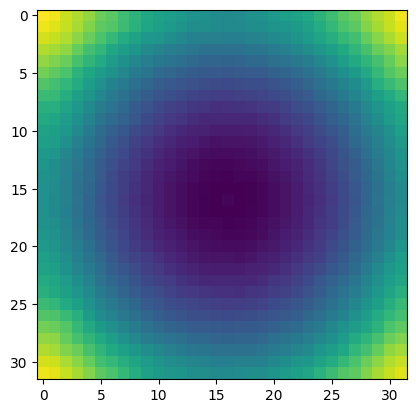

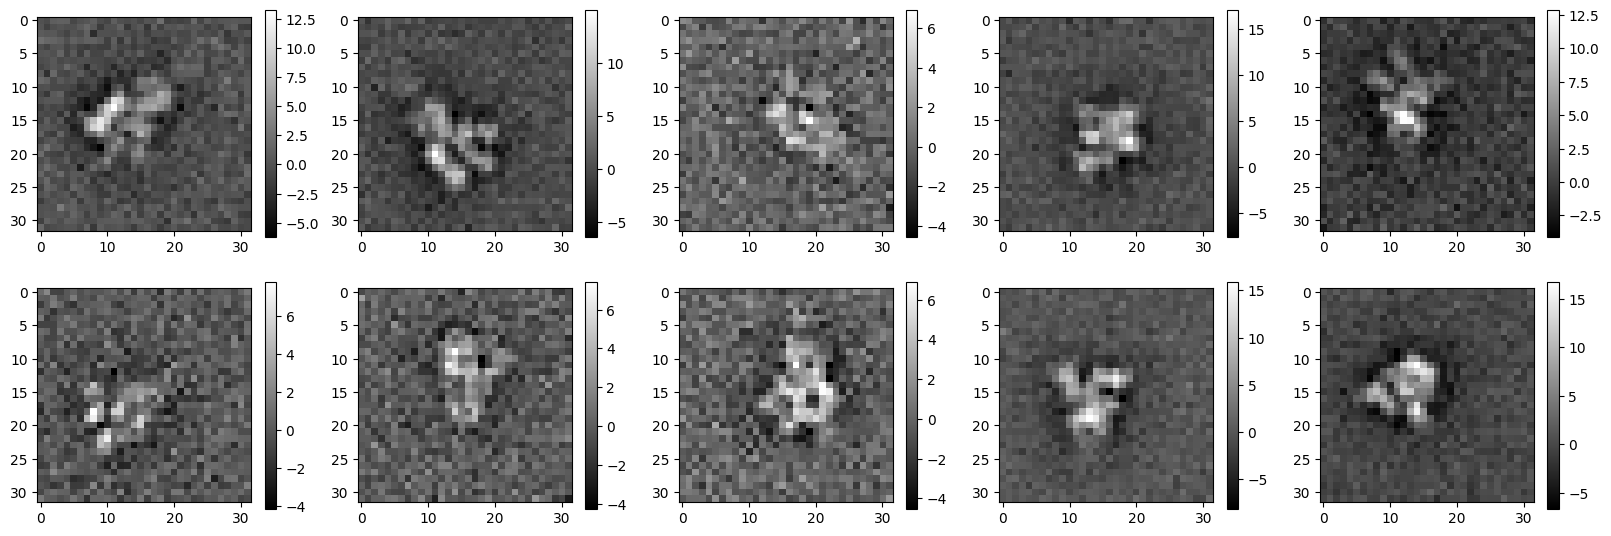

In [4]:
og_v = Volume.load("map-data/emd_14930.map.gz", dtype=np.float64)
logger.info("Original volume map data" f" shape: {og_v.shape} dtype:{og_v.dtype}")

logger.info(f"Downsampling to {(img_size,)*3}")
v = og_v.downsample(img_size)
L = v.resolution


# Then create a filter based on that variance
# This is an example of a custom noise profile
def noise_function(x, y):
    alpha = 1
    beta = 1
    # White
    f1 = noise_variance
    # Violet-ish
    f2 = noise_variance * (x * x + y * y) / L * L
    return (alpha * f1 + beta * f2) / 2.0


custom_noise = CustomNoiseAdder(noise_filter=FunctionFilter(noise_function))

logger.info("Initialize CTF filters.")
# Create some CTF effects
pixel_size = 5 * 65 / img_size  # Pixel size of the images (in angstroms)
voltage = 200  # Voltage (in KV)
defocus_min = 1.5e4  # Minimum defocus value (in angstroms)
defocus_max = 2.5e4  # Maximum defocus value (in angstroms)
defocus_ct = 7  # Number of defocus groups.
Cs = 2.0  # Spherical aberration
alpha = 0.1  # Amplitude contrast

# Create filters
ctf_filters = [
    RadialCTFFilter(pixel_size, voltage, defocus=d, Cs=2.0, alpha=0.1)
    for d in np.linspace(defocus_min, defocus_max, defocus_ct)
]

# Finally create the Simulation
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    noise_adder=custom_noise,
    unique_filters=ctf_filters,
    dtype=v.dtype,
)
# Peek
if interactive:
    src.images[:10].show()

# Use phase_flip to attempt correcting for CTF.
logger.info("Perform phase flip to input images.")
src.phase_flip()

# Estimate the noise and `Whiten` based on the estimated noise
aiso_noise_estimator = AnisotropicNoiseEstimator(src)
src.whiten(aiso_noise_estimator.filter)

# Plot the noise profile for inspection
if interactive:
    plt.imshow(aiso_noise_estimator.filter.evaluate_grid(L))
    plt.show()

# Peek, what do the whitened images look like...
if interactive:
    src.images[:10].show()

# Cache to memory for some speedup
#src.cache()

In [5]:
# get rot vecs for each
# normalize
# get fspca from projections
# train templates

basis = FSPCABasis(src=src, components=400, batch_size=512)


2023-03-06 17:43:25,188 INFO [aspire.basis.ffb_2d] Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.
2023-03-06 17:43:25,275 INFO [aspire.basis.fspca] Estimating the noise of images.
2023-03-06 17:43:25,276 INFO [aspire.noise.noise] Determining Noise variance in batches of 512


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]

2023-03-06 17:43:41,616 INFO [aspire.noise.noise] Noise variance = 0.965796554881936
2023-03-06 17:43:41,618 INFO [aspire.basis.fspca] Setting noise_var=0.965796554881936
2023-03-06 17:43:41,619 INFO [aspire.covariance.covar2d] Represent CTF filters in FB basis


RuntimeError: The data has an uncaught error that led to the planner returning NULL. This is a bug.

In [ ]:
sp_rotations = sp_rot.from_matrix(src.rotations)
rot_vecs = sp_rotations.as_rotvec()
rot_vecs /= np.linalg.norm(rot_vecs, axis=-1)[:,np.newaxis]
rot_vecs = torch.from_numpy(rot_vecs)
rot_vecs = torch.stack((rot_vecs,rot_vecs), dim=1).view(2*rot_vecs.shape[0],rot_vecs.shape[1])


coefs = basis.spca_coef
coefs = basis.to_complex(coefs)
coefs = torch.from_numpy(coefs)

In [ ]:
rotvecs_inners = rot_vecs @ rot_vecs.T

: 

: 

In [ ]:
def process_coefs

In [58]:
num_templates = 40
lr = 0.1

indices = torch.randperm(len(coefs))[:num_templates]
coefs_copy = coefs.data.clone()
Z = coefs_copy[indices].requires_grad_(True)

optim = torch.optim.Adam([Z], lr = lr)

def max_filter_torch(Z, coefs, rot_vecs, basis, padding = 400):
    num_temp = Z.shape[0]
    num_pics = coefs.shape[0]
    matrix_result = torch.zeros(num_temp, num_pics*2)

    max_filter_bank = []
    max_filter_bank_refl = []

    for i in range(num_pics):
        output = basis.pca_basis.max_filter_bank(coefs[i], Z, basis.max_filter_fft, padding)
        reg_out = torch.from_numpy(output[0]).view(num_temp,1)
        refl_out = torch.from_numpy(output[1]).view(num_temp,1)
        matrix_result[:,2*i] = reg_out
        matrix_result[:,2*i+1] = refl_out

    return np.array(max_filter_bank), np.array(max_filter_bank_refl)


    basis.max_filter_bank(coefs, Z, basis.max_filter_fft, 400)



def max_filter_torch_on_hold(Z, coefs, rot_vecs, indices, padding = 400):
    num_temp = Z.shape[0]
    num_pics = coefs.shape[0]
    matrix_result = torch.zeros(num_temp, num_pics)
    for i in range(num_temp):
        for j in range(num_pics): 
            # get the max filter
            # add to result

def loss(Z, coefs, rot_vecs, basis):
    vecs = 0
